In [6]:
import os

import pathlib

import pandas as pd
import numpy as np
import json
import yaml
import scikit_posthocs as sp
from scipy import stats

from matplotlib import pyplot as plt

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

In [12]:
def compute_plot_Nemenyi(data, filename, baseline="uniform", model ="resnet50", dataset = "imagenet"):
    ranks = np.array([rankdata(-p) for p in data.values])
    average_ranks = np.mean(ranks, axis=0)
    cd = compute_CD(average_ranks,
                    n=data.shape[0],
                    alpha='0.05',
                    test='nemenyi')
    # This method generates the plot.
    graph_ranks(average_ranks,
                names=list(data),
                cd=cd,
                width=10,
                textspace=2,
                reverse=True)

    plt.savefig(f'{filename}_{model}_{dataset}_baseline_{baseline}.png')
    plt.close()

In [3]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [4]:
def parser_method_dict_with_layers(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Nb_Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
        Note that df.iloc[0] has a dic e.g., {"layer1": [list of corr of bacth], "layer2": [list of corr of batch]}
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]): # loop over the number of batches
        row = yaml.safe_load(df.iloc[i].iloc[0]) # Get the batch result
        
        # p is the index of image, j is the layer_name, np.trapz computes the AUC
        dataf.loc[i] = [np.trapz([row[j][p] for j in row]) for p in range(batch)]
    return dataf

In [16]:
metrics =  ['Faithfulness Estimate', 'Faithfulness Correlation', 
            'Monotonicity Arya','Pixel-Flipping',
            "Selectivity", 'Monotonicity Nguyen']
    
transform = {'Monotonicity Nguyen': lambda x: x, 'Local Lipschitz Estimate': lambda x: -x, 
            'Faithfulness Estimate': abs, 'Faithfulness Correlation': abs, 
            'Avg-Sensitivity': lambda x: -x, 'Random Logit': lambda x: x,
             'Sparseness': lambda x: x, 'EffectiveComplexity': lambda x: -x,
             'Nonsensitivity': lambda x: -x, 'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
             'Max-Sensitivity': lambda x: -x, 'Complexity': lambda x: -x, 
             "Selectivity": lambda x: -parser_method_dict(x), 'Model Parameter Randomisation': lambda x: parser_method_dict_with_layers(x),
             'Monotonicity Arya': lambda x: x,
            }
baselines = ["mean", "black", "white", "random", "uniform"]
    
methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam', 'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]



In [13]:
model = "resnet50"

dico_ranks = {}
alpha = 0.05 #Seuil de significativité

group_nemenyi = {}

dataset = "imagenet"

for metr in metrics:
    pathlib.Path(f'results/variations/{metr}').mkdir(parents=True, exist_ok=True) 
    
for metr in metrics:
    for base in baselines:        
        print("-- Metric: ", metr, base)
        data_nemenyi = pd.DataFrame()
        for meth in methods:
            csv_name = f"csv/baseline_{base}/{meth}_{model}_{dataset}_{metr}_baseline_{base}.csv"
            df = pd.read_csv(csv_name, header = None)
            data_nemenyi[meth] = transform[metr](df).values.flatten()

        #data_nemenyi = transform[metr](data_nemenyi)

        ranks = np.array([rankdata(-p) for p in data_nemenyi.values])
        average_ranks = np.mean(ranks, axis=0)

        dico_ranks[metr] = average_ranks/len(metrics)

        #result = sp.posthoc_nemenyi_friedman(data_nemenyi)
        #Order of methods is changed after being passed to the previous function
        #So reindex them before getting the groups from Nemenyi

        #group_nemenyi[metr] = np.argwhere(result.reindex(methods)[methods].values > alpha)

    #df_ranks = pd.DataFrame(dico_ranks, index= methods)

        compute_plot_Nemenyi(data = data_nemenyi, filename= f'results/variations/{metr}/{metr}', baseline = base)

-- Metric:  Faithfulness Estimate mean
-- Metric:  Faithfulness Estimate black
-- Metric:  Faithfulness Estimate white
-- Metric:  Faithfulness Estimate random
-- Metric:  Faithfulness Estimate uniform
-- Metric:  Faithfulness Correlation mean
-- Metric:  Faithfulness Correlation black
-- Metric:  Faithfulness Correlation white
-- Metric:  Faithfulness Correlation random
-- Metric:  Faithfulness Correlation uniform
-- Metric:  Monotonicity Arya mean
-- Metric:  Monotonicity Arya black
-- Metric:  Monotonicity Arya white
-- Metric:  Monotonicity Arya random
-- Metric:  Monotonicity Arya uniform
-- Metric:  Pixel-Flipping mean
-- Metric:  Pixel-Flipping black
-- Metric:  Pixel-Flipping white
-- Metric:  Pixel-Flipping random
-- Metric:  Pixel-Flipping uniform
-- Metric:  Selectivity mean
-- Metric:  Selectivity black
-- Metric:  Selectivity white
-- Metric:  Selectivity random
-- Metric:  Selectivity uniform


In [27]:
metrics_full =['Monotonicity Nguyen',  'Local Lipschitz Estimate',
            'Faithfulness Estimate', 'Faithfulness Correlation', 
            'Avg-Sensitivity', 'Random Logit',
            'Max-Sensitivity', 'Sparseness', 
            'EffectiveComplexity',  'Monotonicity Arya',
             'Complexity', 'Pixel-Flipping',
            "Selectivity", 'Model Parameter Randomisation'] 


dico_baselines = {}

group_nemenyi = {}
df_ranks = {}

for base in baselines: 
    dico_ranks = {}
    for metr in metrics_full:        
        print("-- Metric: ", metr, base)
        data_nemenyi = pd.DataFrame()
        for meth in methods:
            if metr in metrics:
                csv_name = f"csv/baseline_{base}/{meth}_{model}_{dataset}_{metr}_baseline_{base}.csv"
                df = pd.read_csv(csv_name, header = None)
                data_nemenyi[meth] = transform[metr](df).values.flatten()
            else:
                csv_name = f"results/parsed_csv/processed_{meth}_{model}_{dataset}_{metr}"
                df = pd.read_csv(csv_name, index_col=0)
                df = df["value_per_image"]
                data_nemenyi[meth] = df.values.flatten()

        #data_nemenyi = transform[metr](data_nemenyi)

        ranks = np.array([rankdata(-p) for p in data_nemenyi.values])
        average_ranks = np.mean(ranks, axis=0)

        dico_ranks[metr] = average_ranks/len(methods)

        result = sp.posthoc_nemenyi_friedman(data_nemenyi)
    #Order of methods is changed after being passed to the previous function
    #So reindex them before getting the groups from Nemenyi
    
        group_nemenyi[(metr,base)] = np.argwhere(result.reindex(methods)[methods].values > alpha)

    df_ranks[base] = pd.DataFrame(dico_ranks, index= methods)

df_ranks["uniform"]
#compute_plot_Nemenyi(data= data_nemenyi, filename= metr)

-- Metric:  Monotonicity Nguyen mean
-- Metric:  Local Lipschitz Estimate mean
-- Metric:  Faithfulness Estimate mean
-- Metric:  Faithfulness Correlation mean
-- Metric:  Avg-Sensitivity mean
-- Metric:  Random Logit mean
-- Metric:  Max-Sensitivity mean
-- Metric:  Sparseness mean
-- Metric:  EffectiveComplexity mean
-- Metric:  Monotonicity Arya mean
-- Metric:  Complexity mean
-- Metric:  Pixel-Flipping mean
-- Metric:  Selectivity mean
-- Metric:  Model Parameter Randomisation mean
-- Metric:  Monotonicity Nguyen black
-- Metric:  Local Lipschitz Estimate black
-- Metric:  Faithfulness Estimate black
-- Metric:  Faithfulness Correlation black
-- Metric:  Avg-Sensitivity black
-- Metric:  Random Logit black
-- Metric:  Max-Sensitivity black
-- Metric:  Sparseness black
-- Metric:  EffectiveComplexity black
-- Metric:  Monotonicity Arya black
-- Metric:  Complexity black
-- Metric:  Pixel-Flipping black
-- Metric:  Selectivity black
-- Metric:  Model Parameter Randomisation black
--

,Monotonicity Nguyen,Local Lipschitz Estimate,Faithfulness Estimate,Faithfulness Correlation,Avg-Sensitivity,Random Logit,Max-Sensitivity,Sparseness,EffectiveComplexity,Monotonicity Arya,Complexity,Pixel-Flipping,Selectivity,Model Parameter Randomisation
integratedgrad,0.505955,0.166545,0.517591,0.546227,0.223545,0.251182,0.223591,0.205318,0.307773,0.614364,0.204318,0.364091,0.413182,0.830318
smoothgrad,0.419136,0.334136,0.457727,0.553682,0.090909,0.198773,0.090909,0.647000,0.760273,0.593023,0.659773,0.540727,0.476227,0.182545
guidedbackprop,0.649591,0.136455,0.794909,0.565318,0.232682,0.206227,0.232682,0.102091,0.196318,0.648523,0.100909,0.647227,0.484818,0.875273
rise,0.601727,0.857773,0.474318,0.533955,0.944864,0.656091,0.944955,0.949455,0.747795,0.499727,0.944727,0.493818,0.510000,0.531091
gradcam,0.384682,0.568591,0.437636,0.527273,0.482455,0.541864,0.482545,0.429000,0.322205,0.539591,0.425682,0.486636,0.651500,0.488182
scorecam,0.399091,0.635045,0.455227,0.531955,0.533818,0.631818,0.533773,0.563091,0.534705,0.564364,0.558818,0.519136,0.643091,0.478818
layercam,0.354500,0.845545,0.453455,0.542727,0.715636,0.795818,0.715864,0.779727,0.760273,0.556227,0.777545,0.509909,0.645500,0.512909
random,0.765227,0.745682,0.889455,0.570955,0.654045,0.997409,0.653727,0.617227,0.638432,0.573773,0.605409,0.739545,0.393909,0.843045
sobel,0.860636,0.284773,0.573500,0.553364,0.936182,0.326227,0.936136,0.295636,0.543841,0.486227,0.297091,0.631500,0.549045,0.517682
gaussian,0.569636,0.967636,0.470591,0.549636,0.819318,0.899136,0.819318,0.931727,0.760273,0.369500,0.937091,0.529227,0.600909,0.140500


In [29]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

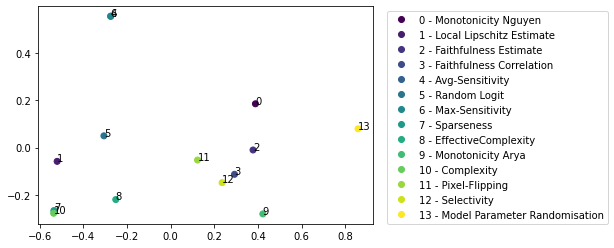

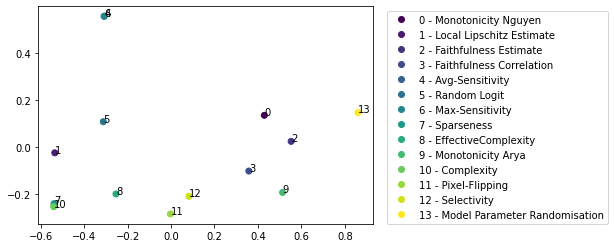

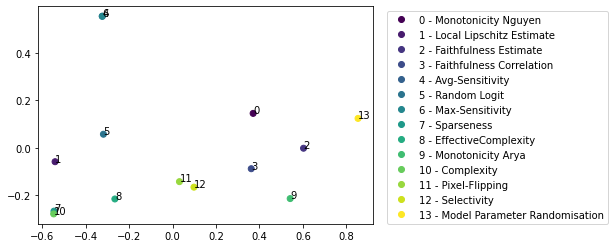

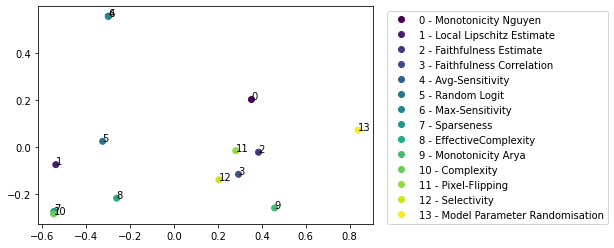

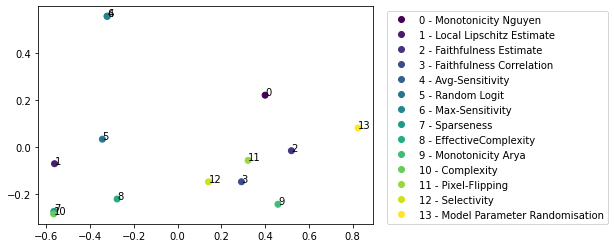

In [35]:
for base in baselines:
    pca = PCA(n_components=2, svd_solver="full")
    df_ranks1 = df_ranks[base].transpose()
    pca.fit(df_ranks1)
    Z = pca.transform(df_ranks1)
    
    sct = plt.scatter(Z[:,0], Z[:,1], c= range(Z.shape[0]))
    for i, txt in enumerate(df_ranks1.index):
        plt.annotate(i, (Z[i,0], Z[i,1]))
    plt.legend(handles=sct.legend_elements()[0], labels=[f"{j} - {metr}" for j, metr in enumerate(metrics_full)],
              loc = (1.04,0))
    plt.savefig(f"results/figures/variations/PCA_{base}.png", bbox_inches='tight')
    plt.show()

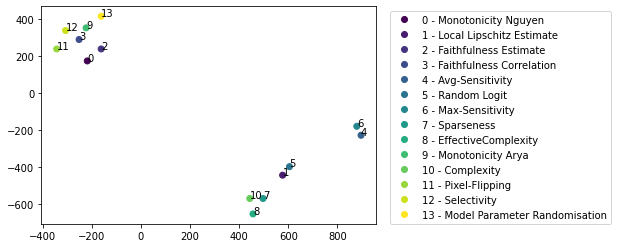

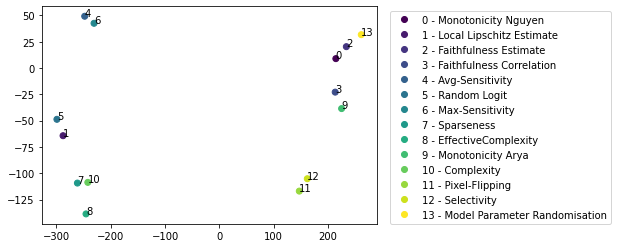

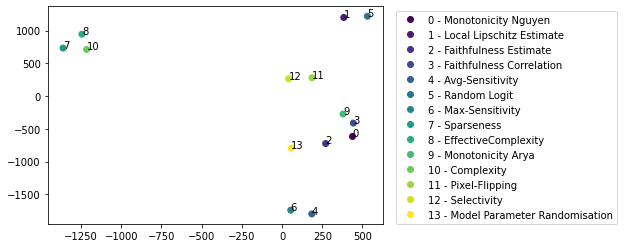

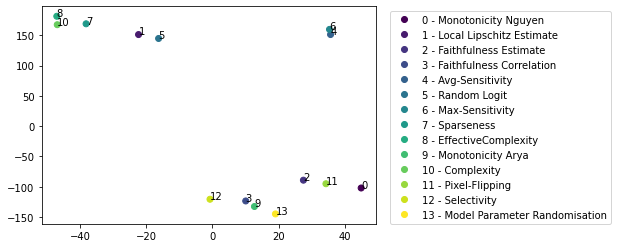

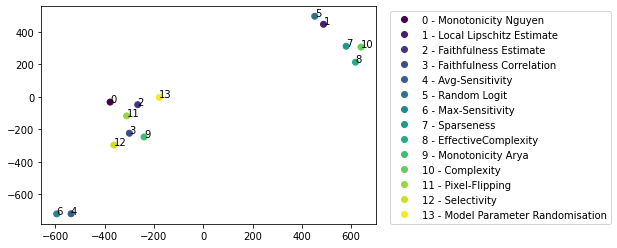

In [37]:
perp = 2
for base in baselines:
    tsne = TSNE(n_components=2, perplexity=perp,
                       init='random', random_state = 1234)
    df_ranks1 = df_ranks[base].transpose()
    X_embedded = tsne.fit_transform(df_ranks1.values)
    scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c= range(X_embedded.shape[0]))
    for i, txt in enumerate(df_ranks1.index):
        plt.annotate(i, (X_embedded[i,0], X_embedded[i,1]))

    plt.legend(handles=scatter.legend_elements()[0], labels=[f"{j} - {metr}" for j, metr in enumerate(metrics_full)],
              loc = (1.04,0))
    plt.savefig(f"results/figures/variations/tsne_{base}.png", bbox_inches='tight')
    plt.show()